## Tweet Emotion Recognition 


## Setup and Imports

* nlp package
* Importing libraries
* preparing visualizations

In [ ]:
!pip install nlp

In [94]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.7.0


## Importing Data

* Importing the Tweet Emotion dataset
* Creating train, validation and test sets
* Extracting tweets and labels

In [5]:
dataset = nlp.load_dataset('emotion')

Downloading:   0%|          | 0.00/3.41k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/6.01k [00:00<?, ?B/s]

Using custom data configuration default


Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/204k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/84e07cd366f4451464584cdbd4958f512bcaddb1e921341e07298ce8a9ce42f4. Subsequent calls will reuse this data.


In [6]:
dataset

{'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [7]:
train = dataset['train']
test = dataset['test']
val = dataset['validation']

In [8]:
def get_tweet(data):
  tweets = [x['text']for x in data]
  labels = [x['label']for x in data]
  return tweets, labels

In [9]:
tweets, labels = get_tweet(train)
tweets[0:5], labels[0:5]

(['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong',
  'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
  'i am feeling grouchy'],
 ['sadness', 'sadness', 'anger', 'love', 'anger'])

## Tokenizer

* Tokenizing the tweets

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [11]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

In [12]:
tokenizer.texts_to_sequences([tweets[3]])


[[2, 24, 165, 8, 665, 27, 6, 4158, 2, 59, 47, 9, 13, 22, 72, 30, 6, 3497]]

In [13]:
tweets[3]

'i am ever feeling nostalgic about the fireplace i will know that it is still on the property'

## Padding and Truncating Sequences

* Checking length of the tweets
* Creating padded sequences

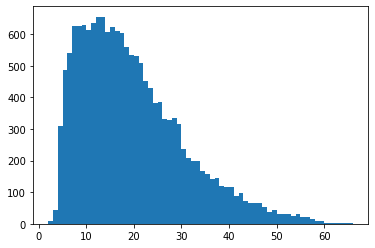

In [14]:
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins=len(set(lengths)))
plt.show()

In [15]:
maxlen = 50
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [16]:
def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating='post', padding='post', maxlen=maxlen)
  return padded

In [17]:
padded_train_sequences = get_sequences(tokenizer, tweets)

In [18]:
padded_train_sequences[3]

array([   2,   24,  165,    8,  665,   27,    6, 4158,    2,   59,   47,
          9,   13,   22,   72,   30,    6, 3497,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

## Preparing the Labels

* Creating classes to index and index to classes dictionaries
* Converting text labels to numeric labels

In [19]:
classes = set(labels)
print(classes)

{'sadness', 'surprise', 'fear', 'anger', 'joy', 'love'}


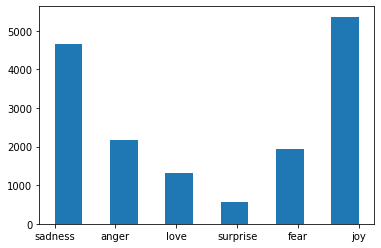

In [20]:
plt.hist(labels, bins=11)
plt.show()

In [21]:
class_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_class = dict((k, v) for v, k in class_to_index.items())

In [22]:
class_to_index


{'anger': 3, 'fear': 2, 'joy': 4, 'love': 5, 'sadness': 0, 'surprise': 1}

In [23]:
index_to_class

{0: 'sadness', 1: 'surprise', 2: 'fear', 3: 'anger', 4: 'joy', 5: 'love'}

In [24]:
names_to_ids = lambda labels : np.array([class_to_index.get(x) for x in labels])

In [25]:
train_labels = names_to_ids(labels)
print(train_labels[2])

3


## Creating the Model

* Creating the model
* Compiling the model

In [26]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(10000, 16, input_length=maxlen),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
        tf.keras.layers.Dense(6, activation='softmax')                           
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            160000    
                                                                 
 bidirectional (Bidirectiona  (None, 50, 40)           5920      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


## Training the Model

* Preparing a validation set
* Training the model

In [28]:
val_tweets, val_labels = get_tweet(val)
val_sequences = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)


In [29]:
val_tweets[0:5], val_labels[0:5]

(['im feeling quite sad and sorry for myself but ill snap out of it soon',
  'i feel like i am still looking at a blank canvas blank pieces of paper',
  'i feel like a faithful servant',
  'i am just feeling cranky and blue',
  'i can have for a treat or if i am feeling festive'],
 array([0, 0, 5, 3, 4]))

In [30]:
F = model.fit(
    padded_train_sequences, train_labels,
    validation_data=(val_sequences, val_labels),
    epochs = 20,
    callbacks=[
               tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
    ]
)

Epoch 1/20
500/500 [==============================] - 39s 61ms/step - loss: 1.3404 - accuracy: 0.4745 - val_loss: 1.0463 - val_accuracy: 0.5870
Epoch 2/20
500/500 [==============================] - 29s 57ms/step - loss: 0.6856 - accuracy: 0.7628 - val_loss: 0.6329 - val_accuracy: 0.7775
Epoch 3/20
500/500 [==============================] - 29s 57ms/step - loss: 0.3827 - accuracy: 0.8699 - val_loss: 0.4597 - val_accuracy: 0.8320
Epoch 4/20
500/500 [==============================] - 28s 57ms/step - loss: 0.2395 - accuracy: 0.9201 - val_loss: 0.4321 - val_accuracy: 0.8660
Epoch 5/20
500/500 [==============================] - 29s 58ms/step - loss: 0.1649 - accuracy: 0.9458 - val_loss: 0.4067 - val_accuracy: 0.8760
Epoch 6/20
500/500 [==============================] - 29s 57ms/step - loss: 0.1257 - accuracy: 0.9596 - val_loss: 0.3879 - val_accuracy: 0.8850
Epoch 7/20
500/500 [==============================] - 29s 58ms/step - loss: 0.1004 - accuracy: 0.9683 - val_loss: 0.4809 - val_accuracy:

##  Evaluating the Model

* Visualizing training history
* Prepraring a test set
* A look at individual predictions on the test set
* A look at all predictions on the test set

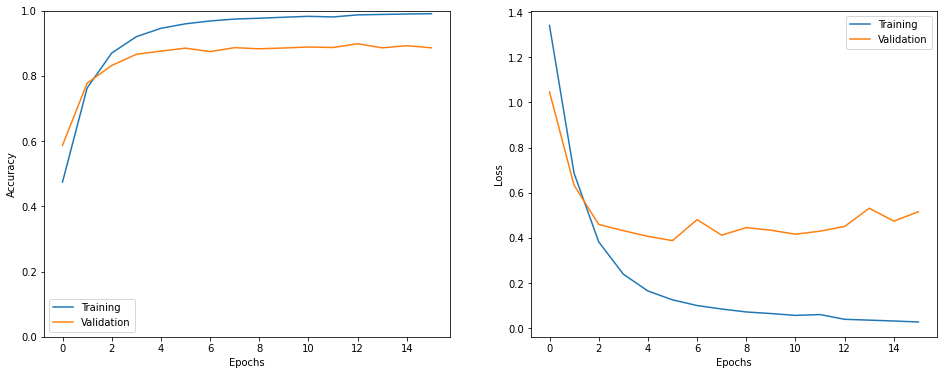

In [31]:
show_history(F)

In [32]:
test_tweets, test_labels = get_tweet(test)
test_seq = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [33]:
evaluation = model.evaluate(test_seq, test_labels)

63/63 [==============================] - 1s 20ms/step - loss: 0.4809 - accuracy: 0.8885


In [90]:
i = random.randint(0, len(test_labels)-1)
print('Tweet:',test_tweets[i])
print('Sentiment:',index_to_class[test_labels[i]])
p = model.predict(np.expand_dims(test_seq[i],axis=0))[0]
predicted_class = index_to_class[np.argmax(p>0.5).astype('uint8')]
print('Predicted emotion:',predicted_class)

Tweet: i have found that some korean men are turning to foreign women because of the freedom they feel it can be easily accounted for that dating between koreans can be a casual thing but more often than not it tends to be a serious matter
Sentiment: joy
Predicted emotion: joy


In [92]:
predictions = np.argmax(model.predict(test_seq), axis=-1)

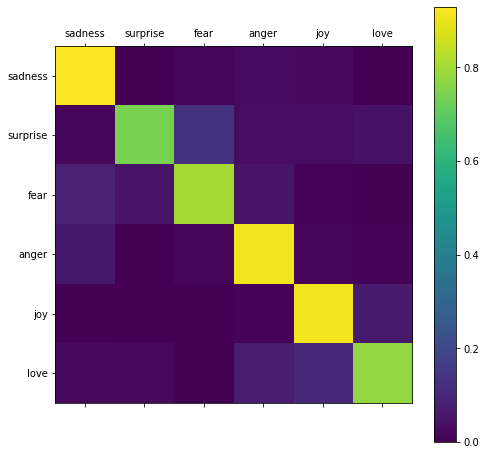

In [93]:
show_confusion_matrix(test_labels, predictions, list(classes))